# EDA, let's find interesting thing in timeseries :)

Thank you for your checking this notebook.

This is my EDA notebook for "H&M Personalized Fashion Recommendations" competition [Link](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/overview).

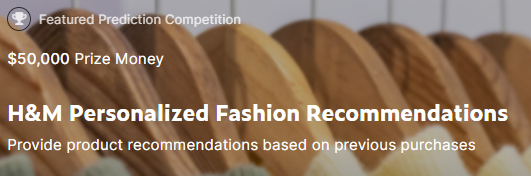

The following 4 .csv files and one folder of images are provided in this competition. 

Our task is to predict <u>what articles each customer will purchase in the 7-day period immediately after the training data ends</u>. 

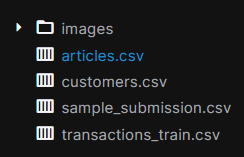

In this notebook, I explore these provided datas and look for interesting informaiton based on time series.

It's still not clear for me how to make a good recommendation based on these data but I believe this EDA would bring me some ideas about next step. 

If you think this notebook is interesting, please leave your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Look into "transactions_train.csv" based on time series](#transaction)
4. [Append key features from "articles.csv" to "transactions_train.csv"](#article)
5. [Append key features from "customers.csv" to "transactions_train.csv"](#customer)
6. [Conclution](#conclution)
7. [Reference](#ref)

<a id='config'></a>

---
## 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
import random
import pprint
from pathlib import Path

In [ ]:
DEBUG = False
PATH_INPUT = r'../input/h-and-m-personalized-fashion-recommendations/'

<a id='load'></a>

---
## 2. Load Data
---

[Back to Contents](#top)

In [ ]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return tt

In [ ]:
dfArticles = pd.read_csv(PATH_INPUT + 'articles.csv')
print(f'The shape of articles.csv is {dfArticles.shape}.\n')
dfArticles.head(3)

In [ ]:
print(f'The number of unique value of each columns.\n')
unique_values(dfArticles)

In [ ]:
dfCustomers = pd.read_csv(PATH_INPUT + 'customers.csv')
print(f'The shape of customers.csv is {dfCustomers.shape}.\n')
dfCustomers.head(3)

In [ ]:
print(f'memory usage of dfCustomers : {dfCustomers.memory_usage(index=True).sum() / 1024 ** 2} KB \n')
dfCustomers['age'] = dfCustomers['age'].fillna(99)
dfCustomers['age'] = dfCustomers['age'].astype('int8')
print(f'memory usage of dfCustomers after change dtype: {dfCustomers.memory_usage(index=True).sum() / 1024 ** 2} KB \n')

In [ ]:
print(f'The number of unique value of each columns.\n')
unique_values(dfCustomers)

In [ ]:
dfSampleSub = pd.read_csv(PATH_INPUT + 'sample_submission.csv')
print(f'The shape of sample_submission.csv is {dfSampleSub.shape}.\n')
dfSampleSub.head(3)

In [ ]:
dfTransactions = pd.read_csv(PATH_INPUT + 'transactions_train.csv', index_col=0, parse_dates=True)
print(f'The shape of transactions_train.csv is {dfTransactions.shape}.\n')
dfTransactions.head(3)

- "Price" is not real value. It's scaled by competion organizer to protect privacy.
- "sales_channel_id" has 1 / 2 values and it means online / offline.
- [Data Questions - Missing Transactions](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/306016#1680549)

In [ ]:
print(f'memory usage of dfTransactions : {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')
dfTransactions['price'] = dfTransactions['price'].astype('float32')
print(f'memory usage of dfTransactions after change dtype: {dfTransactions.memory_usage(index=True).sum() / 1024 ** 2} KB \n')

<a id='transaction'></a>

---
## 3. Look into "transactions_train.csv" based on time series
- "transactions_train.csv" includes the history of purchasing by customers.
- The target of this competition is to predict purchasing results within 7 days after the period which is provided in this file.
---

[Back to Contents](#top)

In [ ]:
oldestDay = dfTransactions.index.min()
latestDay = dfTransactions.index.max()
targetDay = latestDay + pd.DateOffset(days=7)
print(f'The period of train data is from {oldestDay} until {latestDay}.\n')
print(f'So we need to predict purchasing from {latestDay} until {targetDay}.\n')

In [ ]:
dfTransactions['article_id'].resample('M').count().plot(figsize=(15, 10), kind='bar')

In [ ]:
dfTransactions['article_id'].resample('W').count().plot(figsize=(20, 10), kind='bar')

- The peak of sold Qty. was tend to appear arround June.
- The target month, September, did not have so high qty. even consider the lack of data.

In [ ]:
dfUniqCust = dfTransactions.reset_index(drop=False)
dfUniqCust = dfUniqCust[['t_dat', 'customer_id']].drop_duplicates()
dfUniqCust = dfUniqCust.set_index('t_dat')
dfUniqCust['customer_id'].resample('M').count().plot(figsize=(15, 10), kind='bar')

- The trend of number of unique customers are similar to sold Qty of items.
- The peak of number of unique customers is less than 500,000. It is less than 50% of total customers, 1,371,980. So prediciton might be necesary for only 50 % of total customers as well.
- It might be better to classify who would buy during target period before detail prediction because of reducing computing time.

In [ ]:
plt.clf()
plt.close()

In [ ]:
del dfUniqCust, dfSampleSub, oldestDay, latestDay, targetDay 
gc.collect()

In [ ]:
dfTransactions.drop(labels=['price', 'sales_channel_id'], inplace=True, axis=1)

<a id='article'></a>

---
## 4. Append key features from "articles.csv" to "transactions_train.csv"
- Append features "product_group_name", "perceived_colour_master_name" & "index_name" from "articles.csv" to "transactions_train.csv".
- Check seasonality or any other interesting trend of articles.

---

[Back to Contents](#top)

In [ ]:
dfTransArt = dfTransactions.reset_index(drop=False).merge(dfArticles[['article_id', "product_group_name", "perceived_colour_master_name", "index_name"]], on='article_id', how='inner')
dfTransArt = dfTransArt.set_index('t_dat')
dfTransArt.drop(labels=['customer_id'], inplace=True, axis=1)
dfTransArt

In [ ]:
del dfArticles
gc.collect()

In [ ]:
target_period = [['2018-10-01', '2019-09-30'], ['2019-10-01', '2020-09-21']]
target_column = 'product_group_name'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransArt.loc[i[0]:i[1]]
    x = pd.get_dummies(x[target_column], columns=target_column)
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- The reason of peak on June is looks like due to Swimwear and Garment Full body.
- On September, Swimwear was not sold so much but Garment Full body still had ceratin share.

In [ ]:
target_column = 'perceived_colour_master_name'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransArt.loc[i[0]:i[1]]
    x = pd.get_dummies(x[target_column], columns=target_column)
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- Black, white & blue have most of the share.

In [ ]:
target_column = 'index_name'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransArt.loc[i[0]:i[1]]
    x = pd.get_dummies(x[target_column], columns=target_column)
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- "Ladieswear" has the most of share.
- What's the "Divided"? I am asking in Discussion [Link](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/310081)

In [ ]:
# Check the latest popular articles.
# Create new feature from 'product_group_name' & 'perceived_colour_maseter_name'

x = dfTransArt.loc['2020-09-01':'2020-09-30']
x['pg_colour'] = x['product_group_name'] + '_' + x['perceived_colour_master_name']
x = pd.get_dummies(x['pg_colour'], columns='pg_colour')
x = x.astype('int32')
x = x.resample('M').sum().T
x = x.sort_values('2020-09-30', ascending=False)
x.head(40).plot.bar(figsize=(15, 10), stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
plt.clf()
plt.close()

In [ ]:
listPopularArt = x.head(20).index.values.tolist()
print(listPopularArt)

In [ ]:
x = dfTransArt.loc['2020-09-01':'2020-09-30']
x['pg_colour'] = x['product_group_name'] + '_' + x['perceived_colour_master_name']
y = x[x['pg_colour'].isin(listPopularArt)]['article_id'].nunique()
print(f'The number of popular articles in top 20 product group & colour is {y}. \n')

- Created new feature from product group and colour master.
- There were 15, 871 articles in top 20 popular group and colour on Sep in 2020.

In [ ]:
target_period = [['2018-10-01', '2019-09-30'], ['2019-10-01', '2020-09-21']]
target_column = 'pg_colour'
listColumn = []

for i in target_period:    
    x = dfTransArt.loc[i[0]:i[1]]
    x['pg_colour'] = x['product_group_name'] + '_' + x['perceived_colour_master_name']
    x = pd.get_dummies(x[target_column], columns=target_column)
    listColumn.append(x.columns.values.tolist())

In [ ]:
listFeatures = x.sum().sort_values(ascending=False).head(100).index.values.tolist()

In [ ]:
listX = set(listFeatures) & set(listColumn[0]) 
print(len(listX))

In [ ]:
print(listFeatures)

- 100 product grounp & colour conbination would be used as features for training model.

In [ ]:
del dfTransArt
gc.collect()

<a id='customer'></a>

---
## 5. Append key features from "customers.csv" to "transactions_train.csv"
- Append features 'club_member_status', 'fashion_news_frequency' & 'age' from "customers.csv" to "transactions_train.csv".
- Check seasonality or any other interesting trend of customers.

---

[Back to Contents](#top)

In [ ]:
dfTransCust = dfTransactions.reset_index(drop=False).merge(dfCustomers[['customer_id', 'club_member_status', 'fashion_news_frequency', 'age']], on='customer_id', how='inner')
dfTransCust = dfTransCust.set_index('t_dat')
dfTransCust.drop(labels=['article_id'], inplace=True, axis=1)
dfTransCust

In [ ]:
del dfCustomers
gc.collect()

In [ ]:
target_column = 'club_member_status'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransCust.loc[i[0]:i[1]]
    x = pd.get_dummies(x[target_column], columns=target_column)
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- Almost all customers are active.

In [ ]:
target_column = 'fashion_news_frequency'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransCust.loc[i[0]:i[1]]
    x = pd.get_dummies(x[target_column], columns=target_column)
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- "Regulaly" and "None" are 50:50.
- Not so much fractuation of that share.

In [ ]:
target_column = 'age'

for i in target_period:
    print(f'The sold Qty from {i[0]} until {i[1]} by {target_column}. \n')
    
    x = dfTransCust.loc[i[0]:i[1]]
    x['age_bins'] = pd.cut(x[target_column], [-1, 19, 29, 39, 49, 59, 69, 119])
    x = pd.get_dummies(x['age_bins'], columns='age_bins')
    x = x.astype('int32')
    x.resample('M').sum().plot.bar(figsize=(15, 10), stacked=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    plt.clf()
    plt.close()

- 20 ~ 29 years old have the biggest share.
- Each 30 ~ 39, 40 ~ 49, 50 ~ 59 have almost same share.

<a id='conclution'></a>

---

## 6. Conclution

- The period of train data is from 2018.09.20 to 2020.09.21.
- So target period is from 2020.09.22 to 2020.09.29.
- The peak of sold Qty was tend to on June.
- The sold Qty. on September was not so high.
- Prediciton might be necesary for only 50 % of total customers.
- The reason of peak on June was "Swimware" & "Garment Full body".
- "Garment Full body" still had ceratin share on September. There might be colleaction in Summer & Winter.
- The features of customer still does not show valiable informaiton but "age" info could be used.

Thank you for your reading through this Notebook!

Based on this EDA, I am thinking to create a model based on features of articles first. Let's see!

If you think this notebook is interesting for you, please do click upvote :)

---

[Back to Contents](#top)

<a id='ref'></a>

---
## 7. Reference

- [H&M EDA FIRST LOOK](https://www.kaggle.com/vanguarde/h-m-eda-first-look) by DANIIL KARPOV
- [H&M EDA and Prediction](https://www.kaggle.com/gpreda/h-m-eda-and-prediction) by GABRIEL PREDA
- [Pandas.DataFrameのメモリサイズを削減する（最大で8分の1） [Python]](https://qiita.com/nannoki/items/2a8934de31ad2258439d) by @nannoki

---

[Back to Contents](#top)